In [1]:
import csv
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
if not os.path.exists('weights'):
    os.makedirs('weights')

# Data processing

In [4]:
def crop_and_resize(img, mask, size=256):
    '''
    Crop the image to square and resize to 256x256
    
    '''
    # crop to square
    h, w = img.shape
    # print(f'h: {h}, w: {w}')
    if h > w:
        img = img[:w, :]
        mask = mask[:w, :]
    else:
        w_center = w // 2
        img = img[:, w_center - h // 2: (w_center - h // 2)+h]
        mask = mask[:, w_center - h // 2: (w_center - h // 2)+h]

    # resize to 256x256
    img = cv2.resize(img, (size, size))
    mask = cv2.resize(mask, (size, size))

    return img, mask

def data_augmentation(img, mask):
    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_c = clahe.apply(img)
    # horizontal flip
    # https://claire-chang.com/2023/06/09/%E4%BD%BF%E7%94%A8opencv%E5%B0%87%E5%9C%96%E5%BD%A2%E8%BD%89%E6%AD%A3/
    img_f = cv2.flip(img_c, flipCode=1)
    mask_f = cv2.flip(mask, flipCode=1)
    return img_c, img_f, mask_f

def img_normalize(img, mask):
    # 0~255 -> 0~1
    img = img / 255

    # 0~255 -> 0 or 1
    # binary_mask = mask.copy()
    # binary_mask[mask > 128] = 1
    # binary_mask[mask <= 128] = 0
    binary_mask = to_binary_mask(mask)

    img = img.astype(np.float32)
    binary_mask = binary_mask.astype(np.float32)

    img = np.expand_dims(img, axis=-1)
    binary_mask = np.expand_dims(binary_mask, axis=-1)

    return img, binary_mask

def to_binary_mask(mask):
    max_value = np.max(mask)
    binary_mask = mask.copy()
    binary_mask[mask > max_value/2] = 1
    binary_mask[mask <= max_value/2] = 0
    return binary_mask

In [5]:
def load_img_from_one_folder(folder_name, sub_folder_name):
    imgs = []
    masks = []

    # img files list
    file_list = os.listdir(os.path.join('ETT_v3', folder_name, sub_folder_name))

    for file_num in range(len(file_list)):
        print(f'loading {folder_name}/{sub_folder_name}: {file_num+1}/{len(file_list)}', end='\r')

        file_name = file_list[file_num]
        img_path = os.path.join('ETT_v3', folder_name, sub_folder_name, file_name)
        mask_path = os.path.join('ETT_v3', folder_name, sub_folder_name+'annot', file_name.replace('.jpg', '.png'))

        if not (os.path.isfile(img_path)):
            # img does not exist
            print(f'file {img_path} not exist')
            continue
        elif not (os.path.isfile(mask_path)):
            # same name mask does not exist
            mask_path = mask_path.replace('img', 'mask')
            if not (os.path.isfile(mask_path)):
                # another name mask does not exist
                print(f'file {mask_path} not exist')
                continue

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # plt.subplot(3, 2, 1)
        # plt.imshow(img, cmap='gray')
        # plt.subplot(3, 2, 2)
        # plt.imshow(mask, cmap='gray')

        # crop and resize
        img, mask = crop_and_resize(img, mask)

        # data augmentation (CLAHE, horizontal flip)
        img, img_f, mask_f = data_augmentation(img, mask)

        # plt.subplot(3, 2, 3)
        # plt.imshow(img, cmap='gray')
        # plt.subplot(3, 2, 4)
        # plt.imshow(mask, cmap='gray')
        # plt.subplot(3, 2, 5)
        # plt.imshow(img_f, cmap='gray')
        # plt.subplot(3, 2, 6)
        # plt.imshow(mask_f, cmap='gray')

        # normalize
        img, mask = img_normalize(img, mask)
        img_f, mask_f = img_normalize(img_f, mask_f)

        imgs.append(img)
        masks.append(mask)
        imgs.append(img_f)
        masks.append(mask_f)

    print('')

    imgs = np.array(imgs)
    masks = np.array(masks)

    return imgs, masks

# img = cv2.imread(r'ETT_v3\Fold1\train\img_1.2.826.0.1.3680043.8.498.10017127632518130787233241824845923514.jpg', cv2.IMREAD_GRAYSCALE)
# mask = cv2.imread(r'ETT_v3\Fold1\trainannot\mask_1.2.826.0.1.3680043.8.498.10017127632518130787233241824845923514.png', cv2.IMREAD_GRAYSCALE)
# plt.subplot(3, 2, 1)
# plt.imshow(img, cmap='gray')
# plt.subplot(3, 2, 2)
# plt.imshow(mask, cmap='gray')
# img, mask = crop_and_resize(img, mask)
# img, img_f, mask_f = data_augmentation(img, mask)
# plt.subplot(3, 2, 3)
# plt.imshow(img, cmap='gray')
# plt.subplot(3, 2, 4)
# plt.imshow(mask, cmap='gray')
# plt.subplot(3, 2, 5)
# plt.imshow(img_f, cmap='gray')
# plt.subplot(3, 2, 6)
# plt.imshow(mask_f, cmap='gray')
# img, mask = img_normalize(img, mask)

# SegNet

參考資料:[[TF-Keras]SegNet-Starter-Submission - Kaggle](https://www.kaggle.com/code/salmankhaliq22/tf-keras-segnet-starter-submission)

In [6]:
# https://www.kaggle.com/code/salmankhaliq22/tf-keras-segnet-starter-submission

def segnet_encoder_block(inputs, filters_num, kernel_size=3, padding='same', pool_size=2):
    # first layer
    x = keras.layers.Conv2D(filters_num, (kernel_size, kernel_size), padding=padding)(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    # second layer
    x = keras.layers.Conv2D(filters_num, (kernel_size, kernel_size), padding=padding)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    # pooling layer
    pool = keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size))(x)
    return pool

def segnet_decoder_block(inputs, filters_num, kernel_size=3, padding='same'):
    # first layer
    x = keras.layers.UpSampling2D(size=(2, 2))(inputs)
    # second layer
    x = keras.layers.Conv2D(filters_num, (kernel_size, kernel_size), padding=padding)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    # third layer
    x = keras.layers.Conv2D(filters_num, (kernel_size, kernel_size), padding=padding)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    return x

def segnet(input_shape, classes_num=1):
    input = keras.layers.Input(shape=input_shape)

    # encoder
    pool1 = segnet_encoder_block(input, 64)
    pool2 = segnet_encoder_block(pool1, 128)
    pool3 = segnet_encoder_block(pool2, 256)
    pool4 = segnet_encoder_block(pool3, 512)

    # decoder
    x = segnet_decoder_block(pool4, 512)
    x = segnet_decoder_block(x, 256)
    x = segnet_decoder_block(x, 128)
    x = segnet_decoder_block(x, 64)

    # output
    output = keras.layers.Conv2D(classes_num, (1, 1), padding='same', activation='sigmoid')(x)

    model = keras.models.Model(input, output)
    return model

def iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / union

def iou_ccalculate(y_true, y_pred, pixels_per_cm=72):
    absolute_difference = tf.abs(y_true - y_pred)

    mean_error = tf.reduce_mean(absolute_difference) / pixels_per_cm
    accuracy_within_50mm = tf.reduce_mean(tf.cast(absolute_difference <= (pixels_per_cm / 2), tf.float32)) * 100
    accuracy_within_1cm = tf.reduce_mean(tf.cast(absolute_difference <= pixels_per_cm, tf.float32)) * 100

    return mean_error, accuracy_within_50mm, accuracy_within_1cm

# Model Training

In [ ]:
folders_list = os.listdir('ETT_v3')
# folders_list = folders_list[:1]

for folder_name in folders_list:
    # Folder 1 ~ Folder 6
    # Load data
    train_imgs, train_masks = load_img_from_one_folder(folder_name, 'train')
    valid_imgs, valid_masks = load_img_from_one_folder(folder_name, 'val')
    # test_imgs, test_masks = load_img_from_one_folder(folder_name, 'test')
    # create model
    model = segnet((256, 256, 1))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy')
    # train model
    callbacks = [
        keras.callbacks.ModelCheckpoint(os.path.join('weights', f'segnet_{folder_name}.h5'), save_best_only=True, save_weights_only=True, mode='min'),
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
    history = model.fit(train_imgs,
                        train_masks,
                        validation_data=(valid_imgs, valid_masks),
                        epochs=50,
                        batch_size=16)
    if not os.path.exists(os.path.join('weights', f'segnet_{folder_name}.h5')):
        model.save_weights(os.path.join('weights', f'segnet_{folder_name}.h5'))
    else:
        model.load_weights(os.path.join('weights', f'segnet_{folder_name}.h5'))

    shutil.copyfile(os.path.join('weights', f'segnet_{folder_name}.h5'), os.path.join('/content/drive/MyDrive', f'segnet_{folder_name}.h5'))

    print(f'Folder {folder_name} training done')

    tf.keras.backend.clear_session()

# Model evaluate

In [11]:
with open('result.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Folder', 'Mean Error', 'Accuracy within 50mm', 'Accuracy within 1cm'])

In [12]:
folders_list = os.listdir('ETT_v3')

for folder_name in folders_list:
    # Folder 1 ~ Folder 6
    # Load data
    # train_imgs, train_masks = load_img_from_one_folder(folder_name, 'train')
    # valid_imgs, valid_masks = load_img_from_one_folder(folder_name, 'val')
    test_imgs, test_masks = load_img_from_one_folder(folder_name, 'test')
    # load model
    model = segnet((256, 256, 1))
    model.load_weights(os.path.join('weights', f'segnet_{folder_name}.h5'))
    #test model
    pre_mask = model.predict(test_imgs, batch_size=2, verbose=0)
    # calculate iou
    mean_error = []
    accuracy_within_50mm = []
    accuracy_within_1cm = []
    for i in range(len(test_imgs)):
        # test model
        test_pred_masks = to_binary_mask(pre_mask[i])
        me, aw50, aw1 = iou_ccalculate(test_masks[i], test_pred_masks)
        mean_error.append(me)
        accuracy_within_50mm.append(aw50)
        accuracy_within_1cm.append(aw1)
    mean_error = np.mean(mean_error)
    accuracy_within_50mm = np.mean(accuracy_within_50mm)
    accuracy_within_1cm = np.mean(accuracy_within_1cm)
    print(f'Folder {folder_name} mean_error: {mean_error:.10f}, accuracy_within_50mm: {accuracy_within_50mm}%, accuracy_within_1cm: {accuracy_within_1cm}%')
    with open('result.csv', 'a+', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([f'{mean_error:.10f}', accuracy_within_50mm, accuracy_within_1cm])
    tf.keras.backend.clear_session()

loading Fold1/test: 47/47
Folder Fold1 mean_error: 0.0000330043, accuracy_within_50mm: 100.0%, accuracy_within_1cm: 100.0%
loading Fold2/test: 47/47
Folder Fold2 mean_error: 0.0000507296, accuracy_within_50mm: 100.0%, accuracy_within_1cm: 100.0%
loading Fold3/test: 47/47
Folder Fold3 mean_error: 0.0000389879, accuracy_within_50mm: 100.0%, accuracy_within_1cm: 100.0%
loading Fold4/test: 48/48
Folder Fold4 mean_error: 0.0000626776, accuracy_within_50mm: 100.0%, accuracy_within_1cm: 100.0%
loading Fold5/test: 48/48
Folder Fold5 mean_error: 0.0000490745, accuracy_within_50mm: 100.0%, accuracy_within_1cm: 100.0%


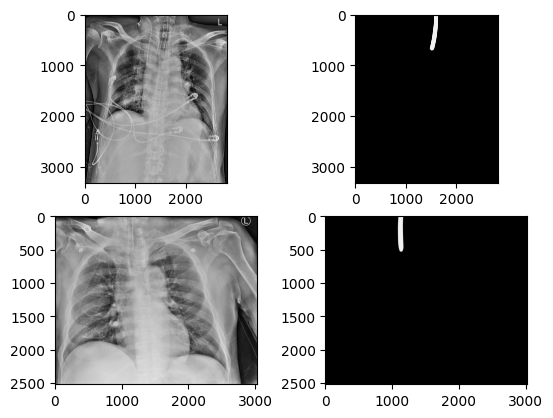

In [8]:
img1 = cv2.imread(r'ETT_v3\Fold1\test\A_0.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(r'ETT_v3\Fold1\test\A_0_6.jpg', cv2.IMREAD_GRAYSCALE)
mask1 = cv2.imread(r'ETT_v3\Fold1\testannot\A_0.png', cv2.IMREAD_GRAYSCALE)
mask2 = cv2.imread(r'ETT_v3\Fold1\testannot\A_0_6.png', cv2.IMREAD_GRAYSCALE)
plt.subplot(2, 2, 1)
plt.imshow(img1, cmap='gray')
plt.subplot(2, 2, 2)
plt.imshow(mask1, cmap='gray')
plt.subplot(2, 2, 3)
plt.imshow(img2, cmap='gray')
plt.subplot(2, 2, 4)
plt.imshow(mask2, cmap='gray')

In [ ]:
model = segnet((256, 256, 1))
model.load_weights(os.path.join('weights', 'segnet_Fold1.h5'))

test_imgs, test_masks = load_img_from_one_folder('Fold1', 'test')

1/1 [==============================] - 0s 58ms/step


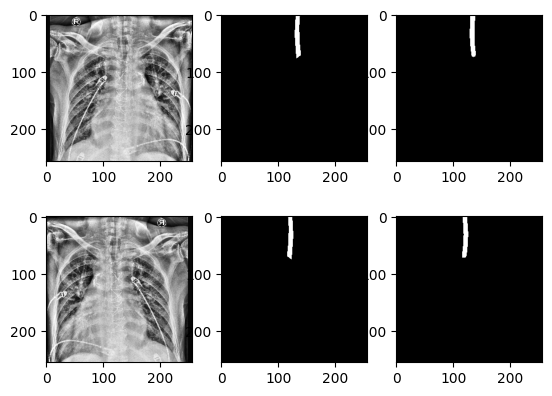

: 

In [13]:
pre_mask = model.predict(test_imgs[:1])
binary_mask = to_binary_mask(pre_mask[0])
plt.subplot(2, 3, 1)
plt.imshow(test_imgs[0].reshape(256, 256), cmap='gray')
plt.subplot(2, 3, 2)
plt.imshow(test_masks[0].reshape(256, 256), cmap='gray')
plt.subplot(2, 3, 3)
plt.imshow(binary_mask.reshape(256, 256), cmap='gray')

pre_mask = model.predict(test_imgs[1:2])
binary_mask = to_binary_mask(pre_mask[0])
plt.subplot(2, 3, 4)
plt.imshow(test_imgs[1].reshape(256, 256), cmap='gray')
plt.subplot(2, 3, 5)
plt.imshow(test_masks[1].reshape(256, 256), cmap='gray')
plt.subplot(2, 3, 6)
plt.imshow(binary_mask.reshape(256, 256), cmap='gray')